# Hand Gesture Recognition - Minimal Version
## Training model for 5 gesture classes

In [4]:
# Import necessary libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import imageio
import pickle

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, GRU, GlobalAveragePooling2D, 
    TimeDistributed
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

# Suppress TensorFlow warnings (optional)
tf.get_logger().setLevel('ERROR')

print("Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

# Check GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
else:
    print("GPU not available, using CPU")

Libraries imported successfully
TensorFlow version: 2.13.0
GPU not available, using CPU


In [ ]:
# Setup paths and configuration
import os
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path(os.getcwd()).resolve()
folder_name = (PROJECT_ROOT / "archive").resolve()
print(f"Dataset root: {folder_name}")

# Path utility functions
def resolve_sequence_dir(base_path: Path, sequence_name: str) -> Path:
    """Find correct sequence directory path"""
    candidates = [
        base_path / "train" / sequence_name,
        base_path / "train" / "train" / sequence_name,
        base_path / "val" / sequence_name,
        base_path / "val" / "val" / sequence_name,
    ]
    for path in candidates:
        if path.exists() and path.is_dir():
            return path
    return candidates[0]

def list_sequence_frames(sequence_dir: Path) -> list[str]:
    """Get sorted list of image frames in sequence directory"""
    if not sequence_dir.exists():
        return []
    return sorted(
        [f for f in os.listdir(sequence_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    )

# Load CSV files
train_csv = folder_name / "train.csv"
val_csv = folder_name / "val.csv"
print(f"Train CSV: {train_csv}")
print(f"Val CSV:   {val_csv}")

with train_csv.open("r", encoding="utf-8") as f:
    train_lines = [line.strip() for line in f.readlines() if line.strip()]
with val_csv.open("r", encoding="utf-8") as f:
    val_lines = [line.strip() for line in f.readlines() if line.strip()]

train_doc = np.random.permutation(train_lines)
val_doc = np.random.permutation(val_lines)

# Configuration
batch_size = 12  # So luong mau du lieu trong mot lan truyen qua mang
x, y, z = 224, 224, 30  # La chieu rong, chieu cao va do dai chuoi
num_epochs = 35  # La so vong lap dao tao mo hinh

print(f"Training samples: {len(train_doc)}")
print(f"Validation samples: {len(val_doc)}")

Dataset root: D:\TEST_DA\archive
Train CSV: D:\TEST_DA\archive\train.csv
Val CSV:   D:\TEST_DA\archive\val.csv
Training samples: 670
Validation samples: 100


In [ ]:
# Data generator with MobileNet preprocessing
rng = np.random.default_rng(seed=42)

def apply_augmentation(image: np.ndarray) -> np.ndarray:
    """Lightweight augmentation that keeps gesture orientation."""
    # Random brightness Sang, toi

    if rng.random() < 0.5:
        factor = rng.uniform(0.85, 1.1)
        image = np.clip(image * factor, 0, 255)

    # Random gaussian Nhieu

    if rng.random() < 0.3:
        noise = rng.normal(0, 5, image.shape)
        image = np.clip(image + noise, 0, 255) #tranh dao nghia left-> right

    # Small random contrast Tuong phan


    if rng.random() < 0.3:
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = np.clip((image - mean) * rng.uniform(0.9, 1.1) + mean, 0, 255)
    return image.astype(np.uint8)

def generator_mobilenet_gru(
    source_path: Path,
    folder_list: np.ndarray,
    batch_size: int,
    x: int,
    y: int,
    z: int,
    normalise: bool,
    augment: bool = False,
):
    """Generator for MobileNet + GRU model"""
    print(f"Source path = {source_path}")
    while True:
        t = np.random.permutation(folder_list)
        for i in range(0, len(t), batch_size):
            batch_features = []
            batch_labels = []
            for folder in t[i : i + batch_size]:
                try:
                    parts = folder.strip().split(";")
                    sequence_name = parts[0]
                    label = int(parts[2])
                    sequence_dir = resolve_sequence_dir(source_path, sequence_name)
                    imgs = list_sequence_frames(sequence_dir)
                    if len(imgs) < z:
                        continue
                    source_frames = np.linspace(0, len(imgs) - 1, z).astype(int)
                    batch_data = []
                    for frame_idx in source_frames:
                        image_path = sequence_dir / imgs[frame_idx]
                        image = imageio.imread(image_path)
                        if augment:
                            image = apply_augmentation(image)
                        image_resized = cv2.resize(image, (224, 224))
                        if normalise:
                            image_normalized = tf.keras.applications.mobilenet_v2.preprocess_input(
                                image_resized.astype(np.float32)
                            )
                        else:
                            image_normalized = image_resized.astype(np.float32) / 255.0
                        batch_data.append(image_normalized)
                    batch_features.append(np.array(batch_data))

                    one_hot = np.zeros(5)
                    one_hot[label] = 1
                    batch_labels.append(one_hot)

                except Exception as e:
                    print(f"Error processing {folder}: {e}")
                    continue

            if len(batch_features) > 0:
                yield np.array(batch_features), np.array(batch_labels)

print("Data generator defined successfully")

Data generator defined successfully


In [ ]:
# Model 8: Transfer Learning with MobileNet and GRU (Best performing model)
def create_mobilenet_gru_model(sequence_length: int = 30,
                                train_backbone: bool = True,
                                trainable_layers: int = 20) -> tf.keras.Model:
    """Create MobileNet + GRU model for gesture recognition"""

    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet",
    )

    if train_backbone:
        # Freeze most layers, fine-tune last `trainable_layers`
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    else:
        base_model.trainable = False
    model = Sequential([
        TimeDistributed(base_model, input_shape=(sequence_length, 224, 224, 3)), #Mobinet xử lý 1 ảnh nên sd TimeDistributed
        TimeDistributed(GlobalAveragePooling2D()),                               #Nen dac trung khong gian
        TimeDistributed(Dense(256, activation="relu")),                         #Giam chieu dac trung tang toc do xu ly
        TimeDistributed(Dropout(0.4)),
        GRU(128, return_sequences=True, dropout=0.4), #học mối quan hệ giữa 30 frames liên tiếp
        GRU(64, dropout=0.4), #chỉ lấy frame cuối cùng để phân loại,xử lý sâu
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(5, activation="softmax"),
    ])

    return model

model = create_mobilenet_gru_model(sequence_length=z,
                                    train_backbone=True,
                                    trainable_layers=24)

optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 7, 7, 1280)    2257984   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 1280)          0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 256)           327936    
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 256)           0         
 stributed)                                                      
                                                                 
________________________________________________________

In [8]:
# Setup callbacks (Fixed version)
curr_dt_time = datetime.datetime.now()
model_name = f'gesture_model_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}'

if not os.path.exists(model_name):
    os.makedirs(model_name)

# Fixed callbacks - use .h5 format instead of .keras
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_name, 'best_model.h5'),  # Changed to .h5
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode='max'  # Added mode parameter
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='max'  # Added mode parameter
)

callbacks = [checkpoint, reduce_lr, early_stop]
print(f"Model will be saved to: {model_name}")

Model will be saved to: gesture_model_20250927_005401


In [ ]:
# Create data generators
train_generator = generator_mobilenet_gru(
    folder_name, train_doc, batch_size, x, y, z, normalise=True, augment=True #Mô phỏng điều kiện thực tế (sáng/tối, nhiễu...)Giảm overfitting
)

val_generator = generator_mobilenet_gru(
    folder_name, val_doc, batch_size, x, y, z, normalise=True, augment=False #Không augment dữ liệu validation vì validation phải phản ánh dữ liệu thực tế khong bien đổi
)

# Calculate steps
steps_per_epoch = len(train_doc) // batch_size 
validation_steps = len(val_doc) // batch_size 

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 55
Validation steps: 8


In [10]:
# Train the model
print("Starting training...")
print(f"Training for {num_epochs} epochs with batch size {batch_size}")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training...
Training for 35 epochs with batch size 12
Source path = D:\TEST_DA\archive


C:\Users\PC-SON\AppData\Local\Temp\ipykernel_18600\2676461477.py:124: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Epoch 1/35
55/55 [==============================] - ETA: 0s - loss: 1.5291 - categorical_accuracy: 0.3470 Source path = D:\TEST_DA\archive
Source path = D:\TEST_DA\archive

Epoch 1: val_categorical_accuracy improved from -inf to 0.67708, saving model to gesture_model_20250927_005401\best_model.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.67708, saving model to gesture_model_20250927_005401\best_model.h5


c:\Users\PC-SON\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 621s 11s/step - loss: 1.5291 - categorical_accuracy: 0.3470 - val_loss: 1.2700 - val_categorical_accuracy: 0.6771 - lr: 1.0000e-04
Epoch 2/35
Epoch 2/35
55/55 [==============================] - ETA: 0s - loss: 1.1437 - categorical_accuracy: 0.6170 
Epoch 2: val_categorical_accuracy improved from 0.67708 to 0.80682, saving model to gesture_model_20250927_005401\best_model.h5

Epoch 2: val_categorical_accuracy improved from 0.67708 to 0.80682, saving model to gesture_model_20250927_005401\best_model.h5
55/55 [==============================] - 595s 11s/step - loss: 1.1437 - categorical_accuracy: 0.6170 - val_loss: 0.8415 - val_categorical_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 3/35
55/55 [==============================] - 595s 11s/step - loss: 1.1437 - categorical_accuracy: 0.6170 - val_loss: 0.8415 - val_categorical_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 3/35
55/55 [==============================] - ETA: 0s - loss: 0.7774 - categorical_accuracy:

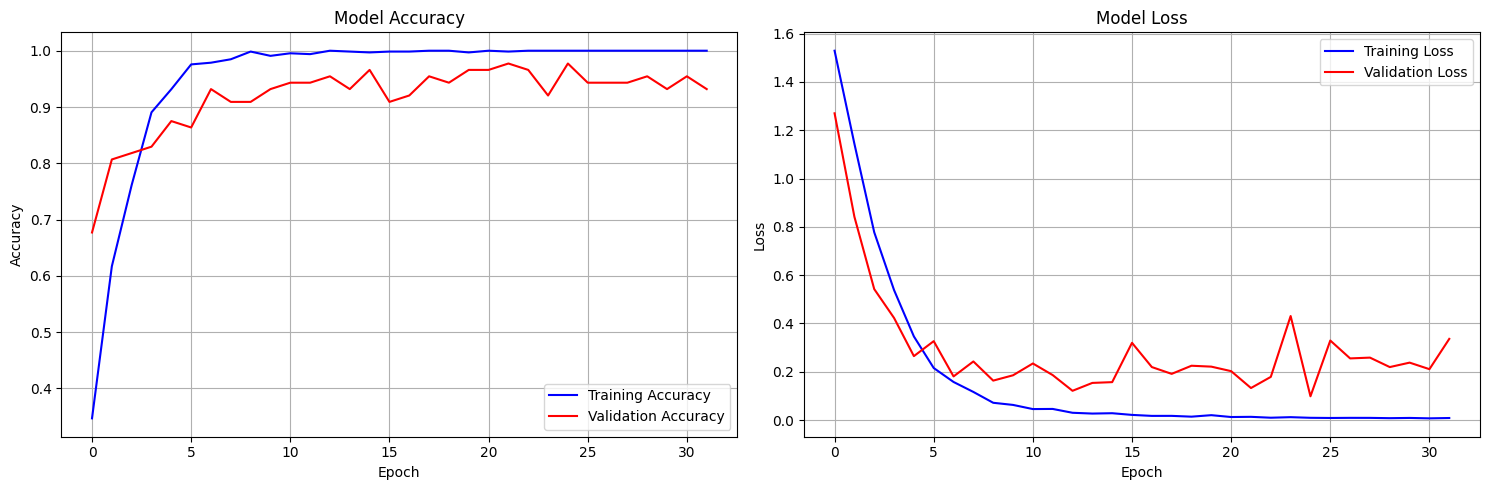


=== TRAINING RESULTS ===
Best Training Accuracy: 1.0000 (100.00%)
Best Validation Accuracy: 0.9773 (97.73%)
Model saved to: gesture_model_20250927_005401


In [11]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final results
    final_train_acc = max(history.history['categorical_accuracy'])
    final_val_acc = max(history.history['val_categorical_accuracy'])
    
    print(f"\n=== TRAINING RESULTS ===")
    print(f"Best Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"Best Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"Model saved to: {model_name}")

# Plot results
plot_training_history(history)

In [12]:
# Save final model (Fixed version)
model.save(os.path.join(model_name, 'final_gesture_model.h5'))  # Changed to .h5
print(f"Final model saved to: {os.path.join(model_name, 'final_gesture_model.h5')}")

# Save training history
import pickle
with open(os.path.join(model_name, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)
    
print("Training complete! Your gesture recognition model is ready.")
print("\n5 gesture classes supported:")
print("0: Thumbs Up")
print("1: Thumbs Down") 
print("2: Left Swipe")
print("3: Right Swipe")
print("4: Stop Gesture")

Final model saved to: gesture_model_20250927_005401\final_gesture_model.h5
Training complete! Your gesture recognition model is ready.

5 gesture classes supported:
0: Thumbs Up
1: Thumbs Down
2: Left Swipe
3: Right Swipe
4: Stop Gesture
